# Problem 1 - Principal Component Analysis
## Part 1: 2-D Synthetic Data Generation

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# repeat from previous homework
def construct_cov_matrix(lambdas, theta):
    u1 = np.array([np.cos(theta), np.sin(theta)])
    u2 = np.array([-np.sin(theta), np.cos(theta)])
    U = np.stack([u1, u2], axis=1)
    L = np.diag(lambdas)
    cov = U @ L @ U.T
    return cov

#parameters
pi_C, pi_D = 0.75, 0.25
mu_C = np.array([0, 0])
mu_D = np.array([-6, -4])

theta_C = np.pi / 3
theta_D = np.pi / 4

cov_C = construct_cov_matrix([1, 2], theta_C)
cov_D = construct_cov_matrix([2, 1], theta_D)

n = 200
n_C = int(pi_C * n)
n_D = n - n_C

np.random.seed(42)
X_C = np.random.multivariate_normal(mu_C, cov_C, n_C)
X_D = np.random.multivariate_normal(mu_D, cov_D, n_D)
X = np.vstack([X_C, X_D])


## Part 2: PCA

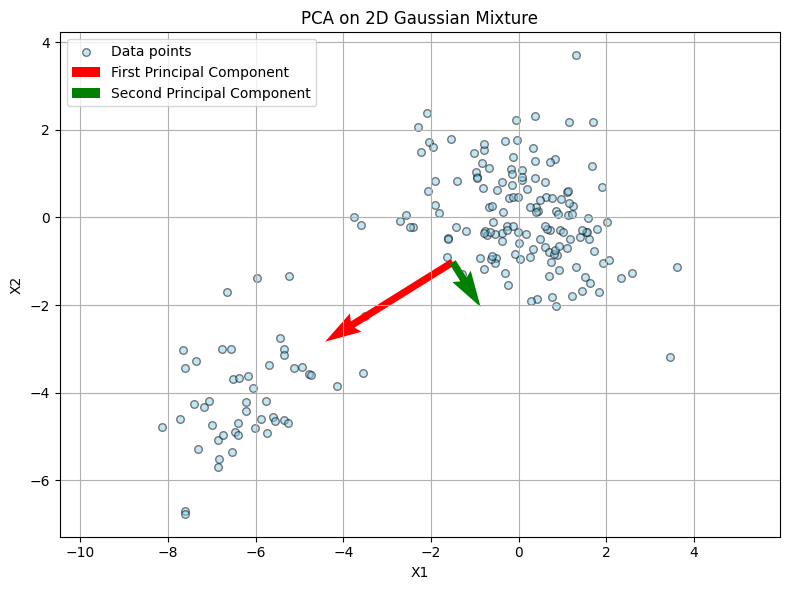

In [43]:

# Function to compute PCA
def pca(X):
    X_centered = X - X.mean(axis=0)
    cov = np.cov(X_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    return eigvecs[:, idx], eigvals[idx]

eigvecs, eigvals = pca(X)
mean = X.mean(axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, s=30, c='skyblue', edgecolor='k', label='Data points')

colors = ['red', 'green']
labels = ['First Principal Component', 'Second Principal Component']

# Draw vectors
for i in range(2):
    v = eigvecs[:, i]
    plt.quiver(mean[0], mean[1], v[0], v[1], scale=1/np.sqrt(eigvals[i]), scale_units='xy', angles='xy', color=colors[i], width=0.01, label=labels[i])

plt.title('PCA on 2D Gaussian Mixture')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Part 3: PCA on the Olivetti faces dataset
### A:

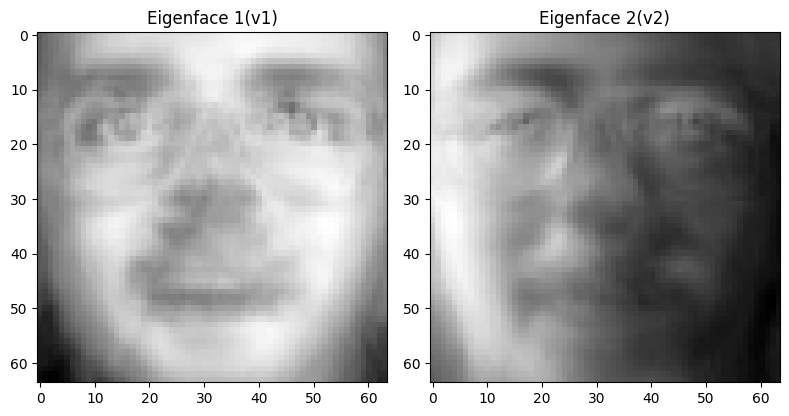

In [44]:

from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler

# get Olivetti dataset
data = fetch_olivetti_faces()
images = data.images
X = data.data         

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get PCA
eigvecs_face, eigvals_face = pca(X_scaled)

# Reshape to image format
v1 = eigvecs_face[:, 0].reshape(64, 64)
v2 = eigvecs_face[:, 1].reshape(64, 64)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(v1, cmap='gray')
axs[0].set_title('Eigenface 1(v1)')
axs[1].imshow(v2, cmap='gray')
axs[1].set_title('Eigenface 2(v2)')
plt.tight_layout()
plt.show()


### B:

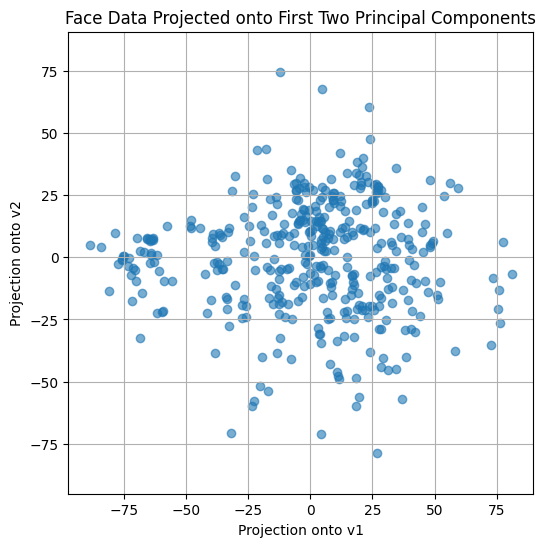

In [45]:
# Get projection onto v1 and v2
z1 = X_scaled @ eigvecs_face[:, 0]
z2 = X_scaled @ eigvecs_face[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(z1, z2, alpha=0.6)
plt.xlabel('Projection onto v1')
plt.ylabel('Projection onto v2')
plt.title('Face Data Projected onto First Two Principal Components')
plt.grid(True)
plt.axis('equal')
plt.show()


### C:

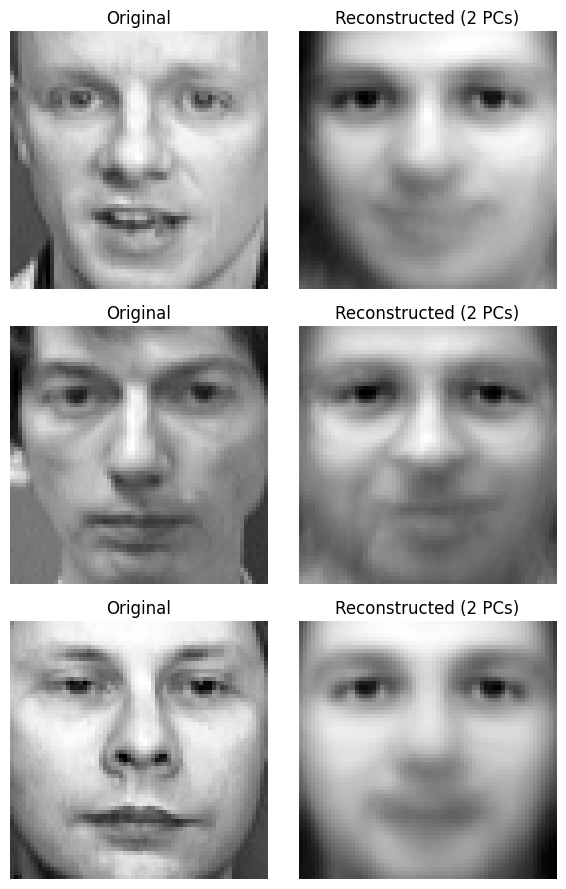

In [46]:
# Get 3 random faces
np.random.seed(42)
indices = np.random.choice(len(X_scaled), size=3, replace=False)

# Project and reconstruct and destandardiz
X_proj = X_scaled @ eigvecs_face[:, :2]
X_recon_2pc = X_proj @ eigvecs_face[:, :2].T
X_recon = scaler.inverse_transform(X_recon_2pc)

fig, axs = plt.subplots(3, 2, figsize=(6, 9))
for i, idx in enumerate(indices):
    axs[i, 0].imshow(X[idx].reshape(64, 64), cmap='gray')
    axs[i, 0].set_title('Original')
    axs[i, 1].imshow(X_recon[idx].reshape(64, 64), cmap='gray')
    axs[i, 1].set_title('Reconstructed (2 PCs)')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()


### D:

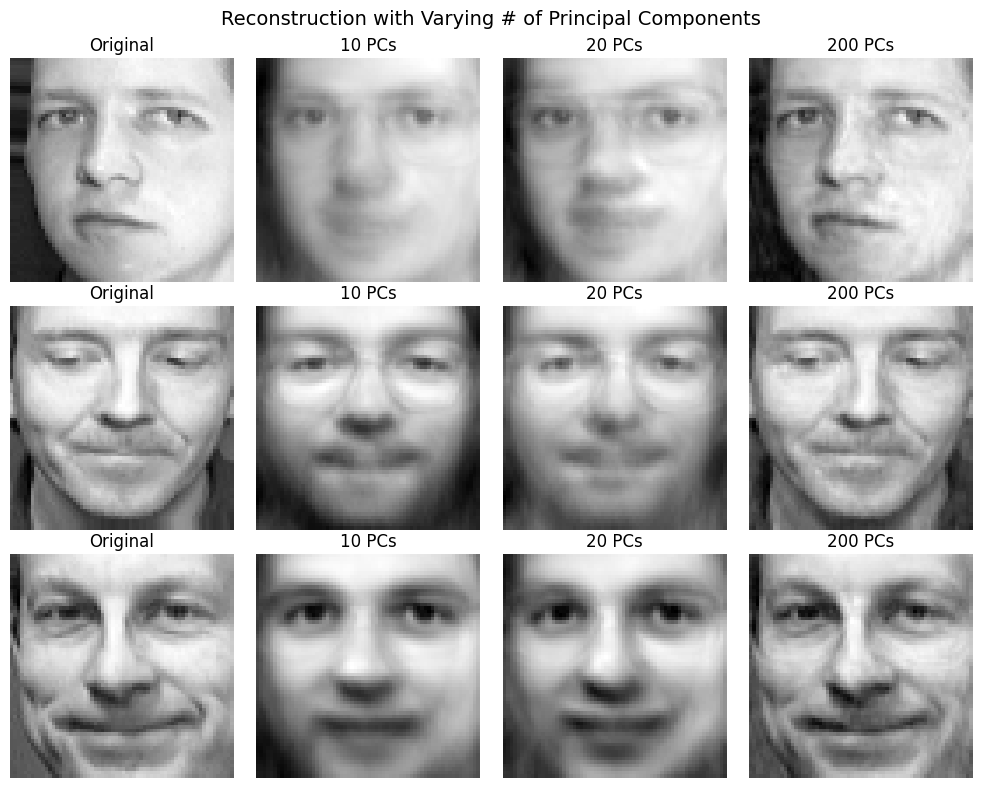

In [47]:
indices = [3, 25, 123] # change these for new images(I didn't want to randomize it)

# use first 10,20,200 PCs
fig, axs = plt.subplots(len(indices), 4, figsize=(10, 8))
k_values = [0, 10, 20, 200]  # 0 is th original image

for row, idx in enumerate(indices):
    axs[row, 0].imshow(X[idx].reshape(64, 64), cmap='gray')
    axs[row, 0].set_title("Original")
    axs[row, 0].axis('off')

    for col, k in enumerate(k_values[1:], start=1):
        Z_k = X_scaled @ eigvecs_face[:, :k]
        X_recon = Z_k @ eigvecs_face[:, :k].T
        X_recon = scaler.inverse_transform(X_recon)
        axs[row, col].imshow(X_recon[idx].reshape(64, 64), cmap='gray')
        axs[row, col].set_title(f"{k} PCs")
        axs[row, col].axis('off')

plt.suptitle("Reconstruction with Varying # of Principal Components", fontsize=14)
plt.tight_layout()
plt.show()



### E:

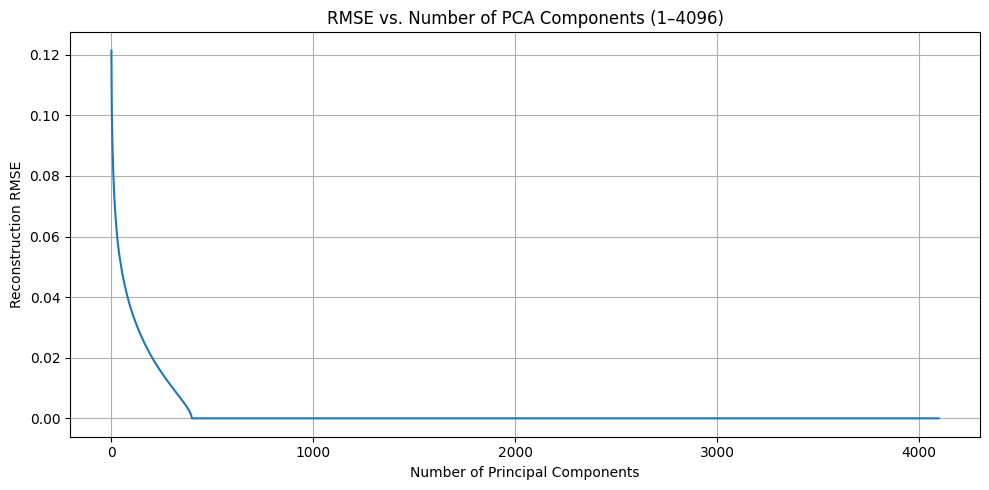

In [48]:
from sklearn.metrics import mean_squared_error

max_components = 4096
rmse_list = []

for k in range(1, max_components + 1):
    k_eff = min(k, eigvecs_face.shape[1])  # max non-zero eigenvectors is 400 i thought

    Z_k = X_scaled @ eigvecs_face[:, :k_eff]
    X_recon = Z_k @ eigvecs_face[:, :k_eff].T
    X_recon = scaler.inverse_transform(X_recon)

    # get RMSE
    rmse = np.sqrt(mean_squared_error(X, X_recon))
    rmse_list.append(rmse)

plt.figure(figsize=(10, 5))
plt.plot(range(1, max_components + 1), rmse_list)
plt.xlabel('Number of Principal Components')
plt.ylabel('Reconstruction RMSE')
plt.title('RMSE vs. Number of PCA Components (1–4096)')
plt.grid(True)
plt.tight_layout()
plt.show()


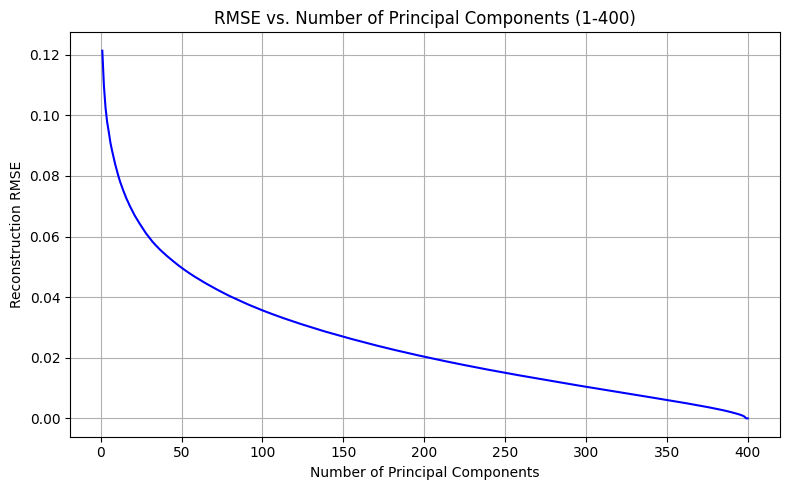

In [49]:

new_rmse = []
component_range = range(1, 401)  # 1 to 400 components for fun

for k in component_range:
    Z_k = X_scaled @ eigvecs_face[:, :k]
    X_recon = Z_k @ eigvecs_face[:, :k].T
    X_recon = scaler.inverse_transform(X_recon)
    rmse = np.sqrt(mean_squared_error(X, X_recon))
    new_rmse.append(rmse)

plt.figure(figsize=(8, 5))
plt.plot(component_range, new_rmse, color='blue')
plt.xlabel("Number of Principal Components")
plt.ylabel("Reconstruction RMSE")
plt.title("RMSE vs. Number of Principal Components (1-400)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Problem 2: XORNet
## Part 1: XORNet with predefined weights
### A:
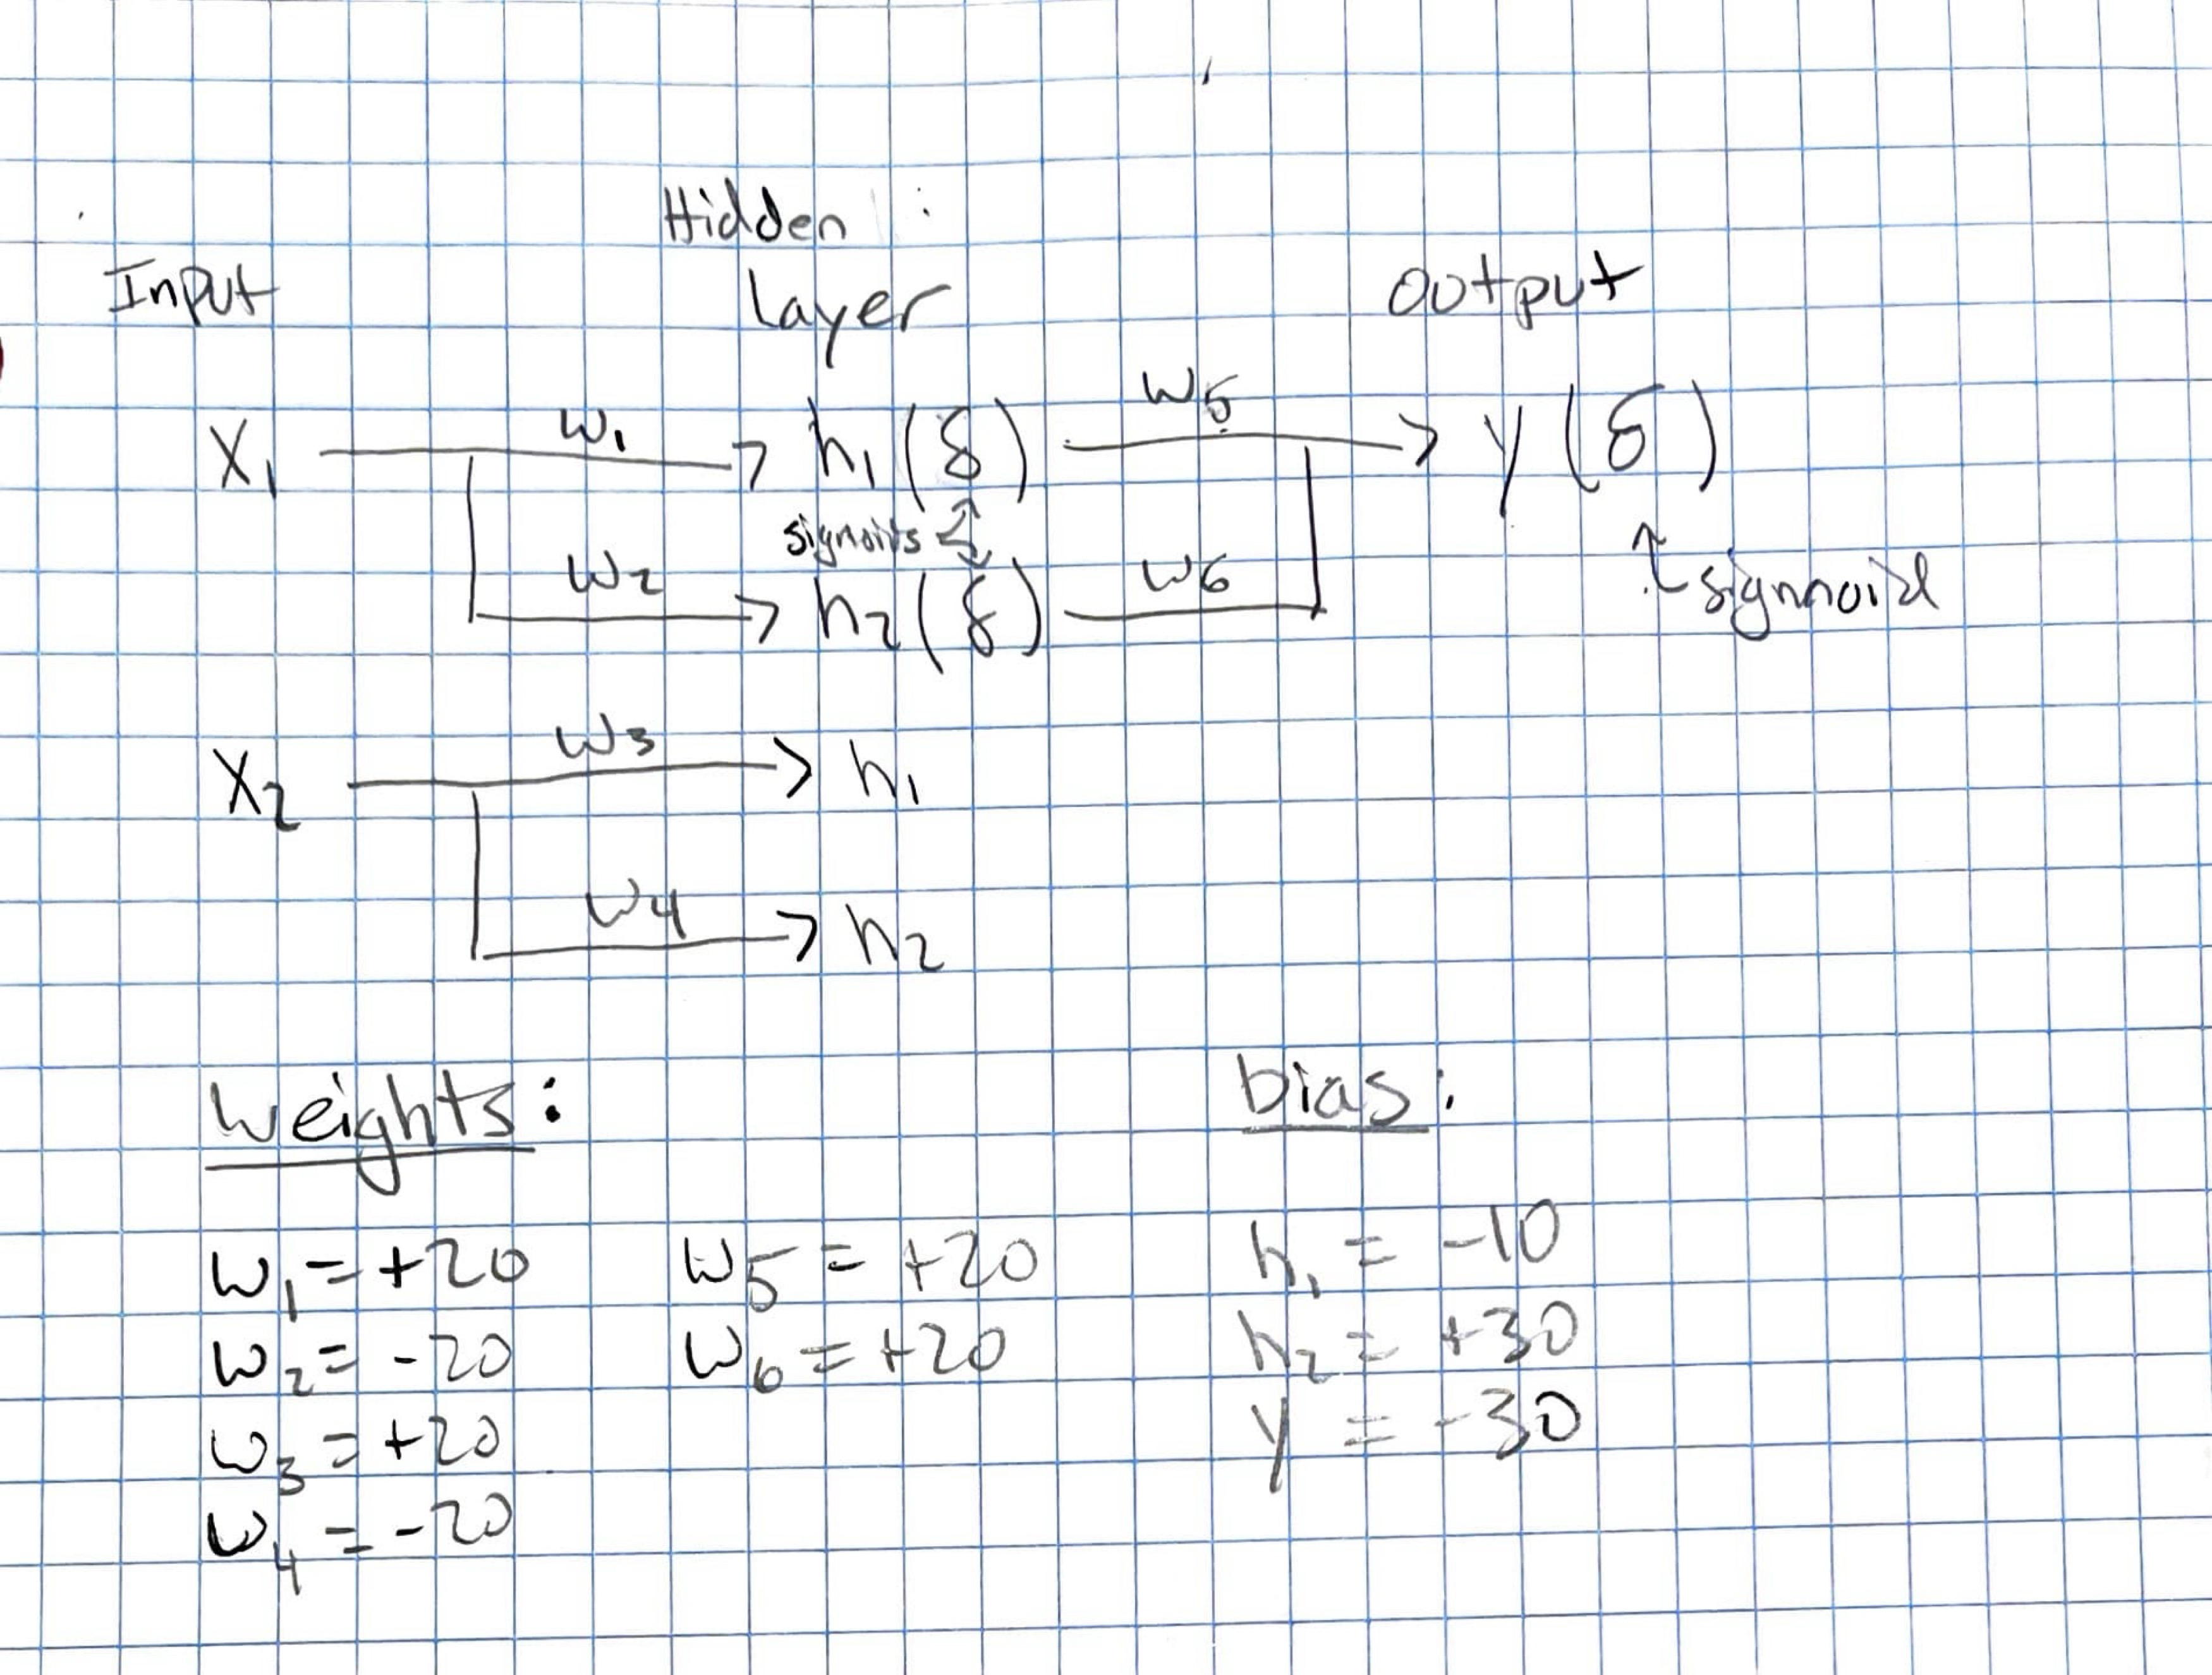
The network has two hidden neurons that learn linearly separable boundaries in the input layer. The first neuron activates when either x1 or x2 is 1. The second neuron suppresses when both are 1. The output neuron combines these to implement XOR logic. (I included my sketch and answer in the overleaf file as well just incase)
### B:

In [50]:
# Manually chose weights
import torch
import torch.nn as nn
import torch.nn.functional as F

class XORNetManual(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

        # Set the weights
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(torch.tensor([[20.0, 20.0],
                                                         [-20.0, -20.0]]))
            self.fc1.bias = nn.Parameter(torch.tensor([-10.0, 30.0]))

            self.fc2.weight = nn.Parameter(torch.tensor([[20.0, 20.0]]))
            self.fc2.bias = nn.Parameter(torch.tensor([-30.0]))

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# input tests
inputs = torch.tensor([[0., 0.],
                       [0., 1.],
                       [1., 0.],
                       [1., 1.]])

model = XORNetManual()
outputs = model(inputs)

for i, out in enumerate(outputs):
    print(f"Input {inputs[i].tolist()} → Output: {out.item():.4f}")


Input [0.0, 0.0] → Output: 0.0000
Input [0.0, 1.0] → Output: 1.0000
Input [1.0, 0.0] → Output: 1.0000
Input [1.0, 1.0] → Output: 0.0000


## Part 2: Training XORNet
### A:

Epoch 0: Loss = 0.694182
Epoch 1000: Loss = 0.692711
Epoch 2000: Loss = 0.690316
Epoch 3000: Loss = 0.675284
Epoch 4000: Loss = 0.600515
Epoch 5000: Loss = 0.483779
Epoch 6000: Loss = 0.220103
Epoch 7000: Loss = 0.085126
Epoch 8000: Loss = 0.048514
Epoch 9000: Loss = 0.033297

Final outputs:
Input [0.0, 0.0] => Output: 0.0274
Input [0.0, 1.0] => Output: 0.9771
Input [1.0, 0.0] => Output: 0.9772
Input [1.0, 1.0] => Output: 0.0262

Learned weights:
Layer fc1.weight:
tensor([[4.3042, 4.2998],
        [6.3734, 6.3453]])
Layer fc1.bias:
tensor([-6.5712, -2.7307])
Layer fc2.weight:
tensor([[-9.6157,  8.9940]])
Layer fc2.bias:
tensor([-4.1057])


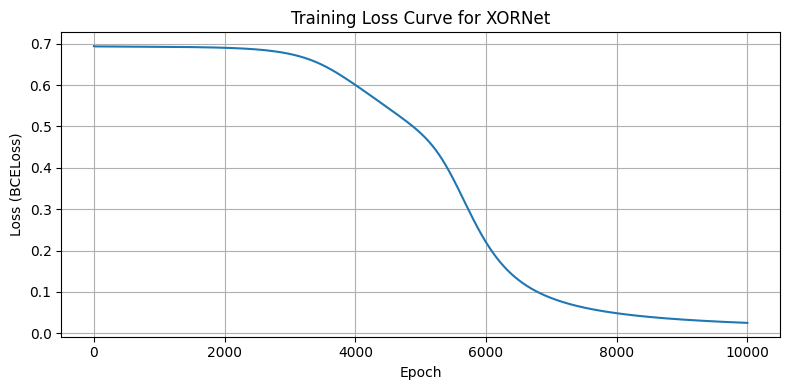

In [56]:
# Define data for training
X = torch.tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])
y = torch.tensor([[0.], [1.], [1.], [0.]])

# create model
class XORNetTrainable(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = XORNetTrainable()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()
losses = []

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Outputs
print("\nFinal outputs:")
with torch.no_grad():
    for i, x in enumerate(X):
        y_pred = model(x.unsqueeze(0)).item()
        print(f"Input {X[i].tolist()} => Output: {y_pred:.4f}")

print("\nLearned weights:")
for name, param in model.named_parameters():
    print(f"Layer {name}:\n{param.data}")

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (BCELoss)")
plt.title("Training Loss Curve for XORNet")
plt.grid(True)
plt.tight_layout()
plt.show()


### B:

The XOR network I made uses chosen weights with high magnitudes to create sharp activations in the hidden layer. This forces the network to behave just like a logical XOR gate, achieving accurate outputs by modeling the required decision boundary.

Without chosing weights, the XOR network starts with random weights and gradually learns the appropriate transformations through backpropagation and gradient descent. After sufficient training, the learned weights also enable the network to model the XOR function accurately, but they tend to have smaller magnitudes and are less extreme than the hand-coded values.

This demonstrates how neural networks can learn complex nonlinear functions like XOR without manually setting parameters. I purposely chose the weights in part 1 to see how close the trained model could get to them.
